In [229]:
'''
    Author:  Varnit Singh
    Date:    7/7/2024
    Purpose: Market Risk Assessment Using Deep Learning Model
    Github: https://github.com/varnit-ta
'''

'\n    Author:  Varnit Singh\n    Date:    7/7/2024\n    Purpose: Market Risk Assessment Using Deep Learning Model\n    Github: https://github.com/varnit-ta\n'

## Training and Evaluating the model

In [230]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [231]:
'''
    Load the data from the csv file and preprocess it.
    The data is stored in a pandas DataFrame.
    The features are stored in a 2D numpy array.
    The target is stored in a 1D numpy array.
    Missing values are filled with the mean.
    The data is normalized to be between 0 and 1.
'''

data = pd.read_csv('data.csv')
features = ['Volatility', 'Beta', 'Market Cap', 'P/E Ratio', 'Dividend Yield', 'Current Ratio', '52 Week High', '52 Week Low']
target = 'Risk Percentage'

X = data[features].values
y = data[target].values

imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [232]:
'''
    Split the data into training and testing sets
    then convert them to PyTorch tensors
'''

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [233]:
'''
    Defining the hyperparameters for the model
    input_size: Number of features
    hidden_size: Number of hidden layers
    num_layers: Number of layers
    output_size: Number of outputs
    dropout_rate: Dropout rate
    learning_rate: Learning rate
    num_epochs: Number of epochs
'''

input_size = len(features)
hidden_size = len(features)
num_layers = 100
output_size = 1
dropout_rate = 0.2
learning_rate = 0.012
num_epochs = 100

In [234]:
'''
    Define the LSTM model
    Args:
        input_size: Number of features
        hidden_size: Number of hidden units
        output_size: Number of output units
        num_layers: Number of LSTM layers
        dropout_rate: Dropout rate
    Returns:
        LSTM model
'''

class MarketRiskLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_rate):
        super(MarketRiskLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        
    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.relu(out[:, -1, :])
        out = self.dropout(out)
        out = self.batch_norm(out)
        out = self.fc(out)
        return out

In [235]:
model = MarketRiskLSTM(input_size, hidden_size, output_size, num_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=0.01)

In [236]:
'''
    Training and testing the model
    
    Args:
        X_train: training data
        y_train: training labels
        X_test: testing data
        y_test: testing labels
        num_epochs: number of epochs
    Returns:
        train_losses: list of training losses
        test_losses: list of testing losses
'''

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train.unsqueeze(1))
    
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        predictions = model(X_test.unsqueeze(1))
        test_loss = criterion(predictions, y_test)
        test_losses.append(test_loss.item())

    if (epoch+1) % 10 == 0:
        print("="*80)
        print("Epoch [{}/{}]".format(epoch+1, num_epochs))
        print("Train Loss: {:.4f}, Test Loss: {:.4f}".format(loss.item(), test_loss.item()))
        print("="*80)

Epoch [10/100]
Train Loss: 1865.8407, Test Loss: 1768.0068
Epoch [20/100]
Train Loss: 1256.5641, Test Loss: 1175.3307
Epoch [30/100]
Train Loss: 786.5953, Test Loss: 726.7231
Epoch [40/100]
Train Loss: 459.3570, Test Loss: 416.4185
Epoch [50/100]
Train Loss: 249.8732, Test Loss: 221.8583
Epoch [60/100]
Train Loss: 127.1153, Test Loss: 110.5973
Epoch [70/100]
Train Loss: 61.8352, Test Loss: 53.1046
Epoch [80/100]
Train Loss: 30.3024, Test Loss: 25.8420
Epoch [90/100]
Train Loss: 16.4348, Test Loss: 14.6082
Epoch [100/100]
Train Loss: 10.9485, Test Loss: 10.5820


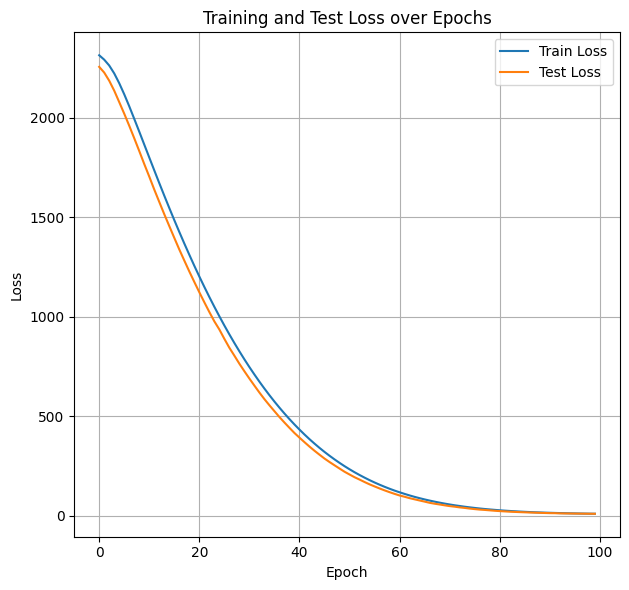

In [237]:
'''
    Plot the training and testing losses over epochs
'''

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [238]:
'''
    Save the model to a file
'''

torch.save(model.state_dict(), 'market_risk_lstm.pth')

## Using the Model by the users

In [247]:
model_path = 'market_risk_lstm.pth'

In [248]:
def preprocess_input(data, scaler):
    imputer = SimpleImputer(strategy='mean')
    data = imputer.fit_transform(data)
    
    data = scaler.transform(data)
    data = torch.tensor(data, dtype=torch.float32)
    return data

In [249]:
'''
    Transfer the model state dict to the new model
    Args:
        model: New model
        state_dict: Model state dict
    Returns:
        New model with transferred state dict
'''

model = MarketRiskLSTM(input_size, hidden_size=hidden_size, output_size=1, num_layers=num_layers, dropout_rate=dropout_rate)
state_dict = torch.load(model_path, map_location=torch.device('cuda'))

In [250]:
'''
    Handle different model architectures by transferring compatible layers
    Args:
        model: New model
        state_dict: Model state dict
    Returns:
        New model with transferred state dict
'''

model_state_dict = model.state_dict()
for name, param in state_dict.items():
    if name in model_state_dict:
        if param.shape == model_state_dict[name].shape:
            model_state_dict[name] = param

In [251]:
model.load_state_dict(model_state_dict)
model.eval()

MarketRiskLSTM(
  (lstm): LSTM(8, 8, num_layers=100, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batch_norm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [252]:
'''
    User input for prediction
    Args:
        features: List of features
    Returns:
        User input values
'''

print("Enter values for the following features:")
user_input = []
for feature in features:
    value = float(input(f"{feature}: "))
    user_input.append(value)

Enter values for the following features:


In [253]:
'''
    Preprocess the user input for prediction
    Args:
        user_input: User input values
        scaler: MinMaxScaler object
    Returns:
        Processed user input
'''

user_input = pd.DataFrame([user_input], columns=features)
user_input_processed = preprocess_input(user_input.values, scaler)

In [254]:
'''
    Predict the risk percentage
    Args:
        user_input_processed: Processed user input
    Returns:
        Predicted risk percentage
'''

with torch.no_grad():
    output = model(user_input_processed.unsqueeze(0)).item()

print(f"\nPredicted Risk Percentage: {output:.2f}")


Predicted Risk Percentage: 46.16
